This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

In [1]:
import tensorflow as tf
tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## 與時間序列有關的深度學習

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

處理dataset

In [3]:
import os
import urllib.request
import ssl

path = os.getcwd() + '\\'
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
def download_file(url):
    files = path + url.split('/')[-1]
    if os.path.isfile(files) == False:
        urllib.request.urlretrieve(url, files)
    print(files)
download_file('https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip')

D:\DLclass\HW\CH10\jena_climate_2009_2016.csv.zip


In [5]:
import zipfile

data_path = os.getcwd()
with zipfile.ZipFile('jena_climate_2009_2016.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(data_path)
    



**Inspecting the data of the Jena weather dataset**

觀察天氣csv裡的各列資料

In [6]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

開始解析

In [13]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

x軸是時間，y軸是溫度

使用matplotlib畫出歷年天氣的所有資料

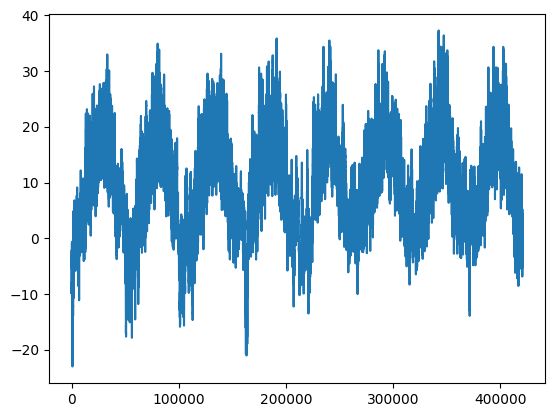

In [14]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

前10天(1440小時)的所有資料

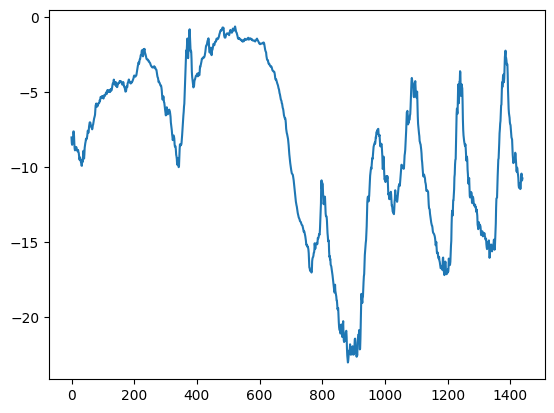

In [15]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

計算要用於train.val.test的樣本數

In [16]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

進行標準化

In [17]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

使用keras的timeseries_dataset_from_array對資料進行預處理

In [18]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

對三個資料堆作處理

In [19]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

觀察shape

In [21]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [25]:
print(len(samples),samples[0],len(targets),targets[0])

256 tf.Tensor(
[[ 0.23170843 -0.60493823 -0.61869123 ... -0.93230685 -0.93001651
  -0.46523441]
 [ 0.17997481 -0.49206605 -0.50363985 ... -0.61931536 -0.62007992
  -0.50017895]
 [ 0.12471391 -0.31420687 -0.32203915 ... -0.34544781 -0.58564252
  -0.54094758]
 ...
 [-1.25445719 -1.24682747 -1.14319014 ... -0.31936518 -0.27570594
   0.1171746 ]
 [-1.24152378 -1.18184046 -1.07889673 ... -0.73016651 -0.57703317
  -0.0703611 ]
 [-1.25328142 -1.10887259 -1.00557967 ... -1.00403407 -0.98167261
   0.23132676]], shape=(120, 14), dtype=float64) 256 tf.Tensor(-0.96, shape=(), dtype=float64)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

計算MAE當作評量基準

In [26]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 9s 9ms/step - loss: 12.6362 - mae: 2.7629 - val_loss: 12.0756 - val_mae: 2.7610
Epoch 2/10
819/819 [==============================] - 7s 9ms/step - loss: 9.0953 - mae: 2.3748 - val_loss: 10.7211 - val_mae: 2.5946
Epoch 3/10
819/819 [==============================] - 7s 9ms/step - loss: 8.3614 - mae: 2.2830 - val_loss: 10.6321 - val_mae: 2.5696
Epoch 4/10
819/819 [==============================] - 6s 8ms/step - loss: 7.8858 - mae: 2.2185 - val_loss: 10.5248 - val_mae: 2.5471
Epoch 5/10
819/819 [==============================] - 6s 8ms/step - loss: 7.5523 - mae: 2.1713 - val_loss: 11.4662 - val_mae: 2.6658
Epoch 6/10
819/819 [==============================] - 7s 8ms/step - loss: 7.2571 - mae: 2.1285 - val_loss: 10.5093 - val_mae: 2.5508
Epoch 7/10
819/819 [==============================] - 7s 8ms/step - loss: 7.0374 - mae: 2.0965 - val_loss: 10.9068 - val_mae: 2.5977
Epoch 8/10
819/819 [==============================] - 7s 8ms/step - 

**Plotting results**

畫出MAE

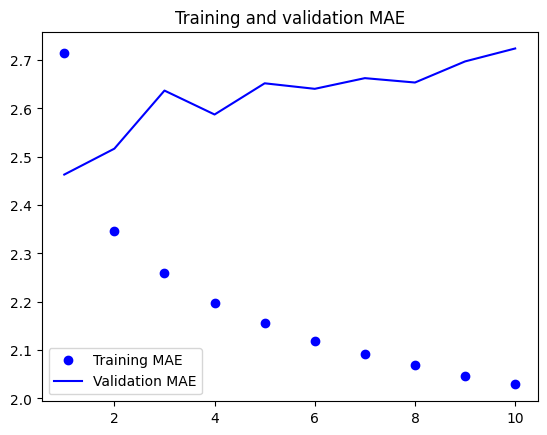

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

## 使用一維的卷積模型

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 12ms/step - loss: 21.3893 - mae: 3.6327 - val_loss: 16.2308 - val_mae: 3.1810
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 15.2379 - mae: 3.0918 - val_loss: 15.0193 - val_mae: 3.0580
Epoch 3/10
819/819 [==============================] - 10s 12ms/step - loss: 13.6993 - mae: 2.9296 - val_loss: 15.1482 - val_mae: 3.1016
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 12.7753 - mae: 2.8291 - val_loss: 14.0768 - val_mae: 2.9583
Epoch 5/10
819/819 [==============================] - 10s 13ms/step - loss: 12.0016 - mae: 2.7383 - val_loss: 15.3390 - val_mae: 3.0813
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 11.4684 - mae: 2.6766 - val_loss: 16.1600 - val_mae: 3.1519
Epoch 7/10
819/819 [==============================] - 10s 13ms/step - loss: 11.0240 - mae: 2.6240 - val_loss: 15.9460 - val_mae: 3.1614
Epoch 8/10
819/819 [=============================

畫出MAE

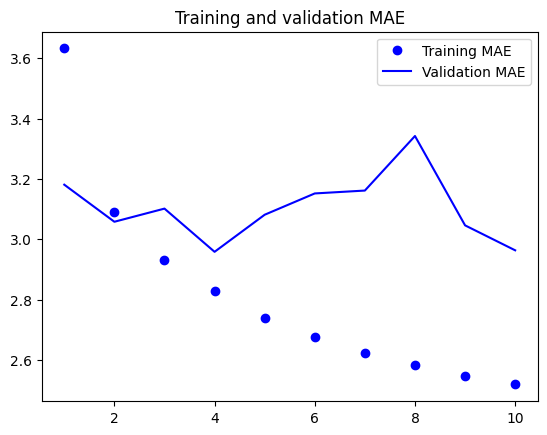

In [29]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### A first recurrent baseline

**A simple LSTM-based model**

簡單的LSTM模型

In [30]:
if keras.backend.backend() =='tensorflow':
    keras.backend.set_image_data_format("channels_last")

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 12s 12ms/step - loss: 40.8651 - mae: 4.6506 - val_loss: 12.0632 - val_mae: 2.6351
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 10.7315 - mae: 2.5526 - val_loss: 9.7477 - val_mae: 2.4367
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 9.7743 - mae: 2.4431 - val_loss: 10.0142 - val_mae: 2.4526
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 9.4638 - mae: 2.4022 - val_loss: 11.1867 - val_mae: 2.5298
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 9.2248 - mae: 2.3705 - val_loss: 10.3590 - val_mae: 2.4848
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 8.9494 - mae: 2.3337 - val_loss: 10.5555 - val_mae: 2.5019
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 8.7102 - mae: 2.3025 - val_loss: 10.6788 - val_mae: 2.5120
Epoch 8/10
819/819 [==============================] - 9s 11m

這邊有出現錯誤: ValueError: Shape must be at least rank 3 but is rank 2 for '{{node BiasAdd}} = BiasAdd[T=DT_FLOAT, data_format="NCHW"](add, bias)' with input shapes: [?,64], [64].

把keras的image_data_format改成"channels_last"就能執行了

畫出使用LSTM的MAE

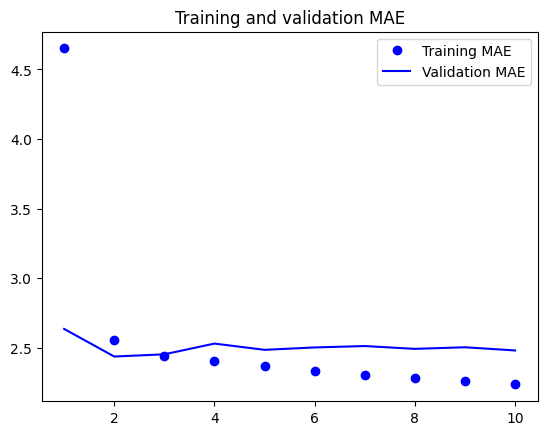

In [31]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

在簡單的RNN模型中使用numpy

In [32]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [33]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [34]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [35]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [36]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

在叫出LSTM時若給他參數會導致無法用cudnn加速，有給參數跟沒給參數相比速度大概差了80倍，所以這邊我先將參數註解掉。

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)



In [38]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 120, 14)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6016      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    batch_size=64,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 11s 12ms/step - loss: 27.2169 - mae: 3.8492 - val_loss: 10.0633 - val_mae: 2.4681
Epoch 2/50
819/819 [==============================] - 9s 11ms/step - loss: 14.5193 - mae: 2.9564 - val_loss: 9.9565 - val_mae: 2.4720
Epoch 3/50
819/819 [==============================] - 10s 12ms/step - loss: 13.5998 - mae: 2.8567 - val_loss: 9.6648 - val_mae: 2.4303
Epoch 4/50
819/819 [==============================] - 9s 11ms/step - loss: 13.0005 - mae: 2.7917 - val_loss: 9.7220 - val_mae: 2.4370
Epoch 5/50
819/819 [==============================] - 9s 11ms/step - loss: 12.4247 - mae: 2.7295 - val_loss: 9.2027 - val_mae: 2.3616
Epoch 6/50
819/819 [==============================] - 9s 11ms/step - loss: 12.0136 - mae: 2.6804 - val_loss: 9.2803 - val_mae: 2.3782
Epoch 7/50
819/819 [==============================] - 10s 12ms/step - loss: 11.5452 - mae: 2.6281 - val_loss: 9.9098 - val_mae: 2.4584
Epoch 8/50
819/819 [==============================] - 9s 1

畫出使用LSTM的MAE

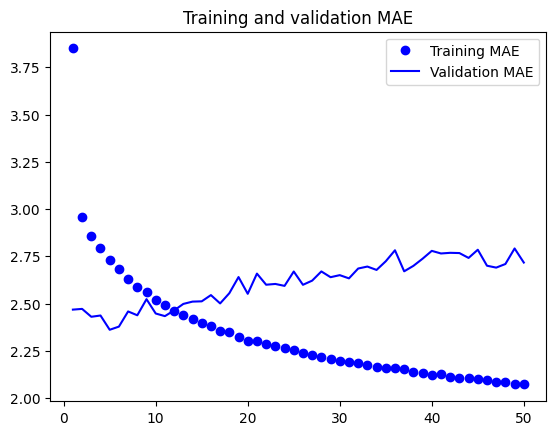

In [40]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [41]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

跟上面一樣註釋掉有給定參數的行

In [42]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
#x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
#x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 11s 12ms/step - loss: 34.6900 - mae: 4.5629 - val_loss: 21.8823 - val_mae: 3.6513
Epoch 2/50
819/819 [==============================] - 10s 12ms/step - loss: 25.3200 - mae: 3.9542 - val_loss: 21.7544 - val_mae: 3.6531
Epoch 3/50
819/819 [==============================] - 10s 12ms/step - loss: 23.8786 - mae: 3.8333 - val_loss: 21.4817 - val_mae: 3.6232
Epoch 4/50
819/819 [==============================] - 10s 12ms/step - loss: 22.9874 - mae: 3.7555 - val_loss: 22.0121 - val_mae: 3.6570
Epoch 5/50
819/819 [==============================] - 10s 12ms/step - loss: 22.2855 - mae: 3.6929 - val_loss: 22.2684 - val_mae: 3.6791
Epoch 6/50
819/819 [==============================] - 10s 12ms/step - loss: 21.6380 - mae: 3.6327 - val_loss: 22.2703 - val_mae: 3.6886
Epoch 7/50
819/819 [==============================] - 10s 12ms/step - loss: 21.0674 - mae: 3.5803 - val_loss: 22.5170 - val_mae: 3.7090
Epoch 8/50
819/819 [============================

畫出使用LSTM的MAE

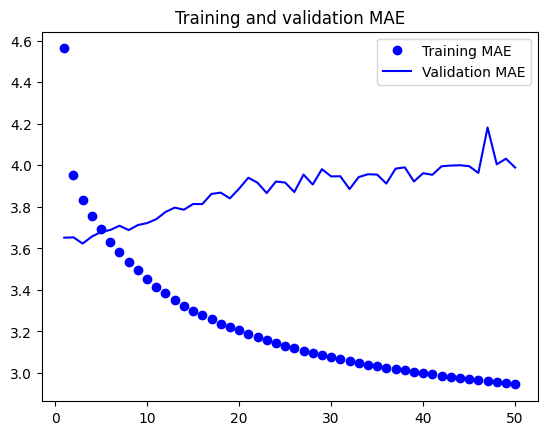

In [43]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

使用bidirectional LSTM

In [44]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 16s 17ms/step - loss: 27.0348 - mae: 3.7133 - val_loss: 10.8377 - val_mae: 2.5598
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 9.5224 - mae: 2.4075 - val_loss: 10.0039 - val_mae: 2.4465
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 8.5897 - mae: 2.2797 - val_loss: 10.2735 - val_mae: 2.4702
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 7.9811 - mae: 2.1930 - val_loss: 10.5227 - val_mae: 2.4956
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 7.5016 - mae: 2.1252 - val_loss: 11.4357 - val_mae: 2.5998
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 7.1096 - mae: 2.0675 - val_loss: 11.6701 - val_mae: 2.6274
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 6.7943 - mae: 2.0239 - val_loss: 11.9041 - val_mae: 2.6448
Epoch 8/10
819/819 [==============================] - 

畫出使用bidirectional LSTM的MAE

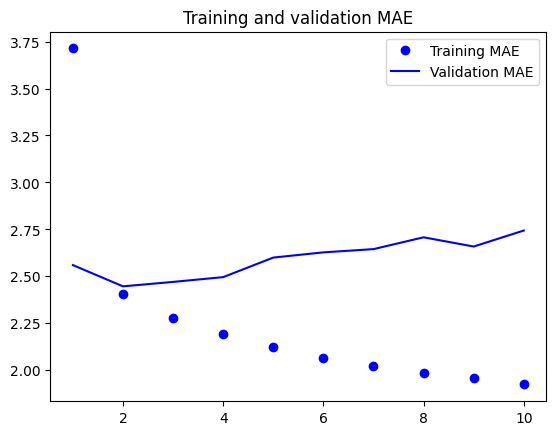

In [45]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Going even further

## Summary